In [1]:
import json
import numpy as np
from unittest.mock import MagicMock
from sklearn.preprocessing import StandardScaler
from megnet.data.qm9 import load_qm9_faber, ring_to_vector, FeatureClean, Scaler
from megnet.data.graph import GraphBatchGenerator
from megnet.models import MEGNetModel


Using TensorFlow backend.


In [2]:
# Load sample qm9 molecules
data_json = '../megnet/data/tests/qm9/qm9.json'
with open(data_json, 'r') as f:
    data = json.load(f)

# Create a mock database and the query return value 
# of the database is the qm9 molecules loaded previously
db = type('Mock', (), {})
db.find = MagicMock(return_value=data)

In [3]:
# Query results, and get graph representation from qm9 data
atom_feature, bond_feature, state_feature, index1, index2, targets = \
    load_qm9_faber(db)

INFO:root:Start querying...



In [4]:
# Clean up the features
# categorical arguments mean the fields that will be considered as categorical
# feature labels mean that total features considered in the current model
atom_fc = FeatureClean(categorical=["type", "chirality", "hybridization", "donor", "acceptor", "aromatic"],
                       feature_labels=["type", "chirality", "ring_sizes", "hybridization", "donor", "acceptor", "aromatic"])
bond_fc = FeatureClean(categorical=["bond_type", "same_ring"],
                       feature_labels=["bond_type", "graph_distance", "same_ring", "spatial_distance"])
state_fc = Scaler()

In [5]:
processed_atom_feature = atom_fc.fit_transform(atom_feature)
processed_bond_feature = bond_fc.fit_transform(bond_feature)
processed_state_feature = state_fc.fit_transform(state_feature)
u0 = np.array(targets.loc[:, "U0"].values, dtype='float64').reshape((-1, 1)) 

In [6]:
# convert internal energy to internal energy per atom
nb_atoms = np.array([len(i) for i in processed_atom_feature])
processed_target = u0 / nb_atoms[:, None]

In [7]:
n_atom_feature = len(processed_atom_feature[0][0])
n_bond_feature = len(processed_bond_feature[0][0])
n_state_feature = processed_state_feature[0].shape[-1]

In [8]:
# feature dimensions
n_atom_feature, n_bond_feature, n_state_feature

(21, 26, 2)

In [9]:
# generator for training
BATCH_SIZE = 4
train_generator = GraphBatchGenerator(processed_atom_feature, processed_bond_feature, processed_state_feature, 
                                     index1, index2, processed_target, batch_size=BATCH_SIZE)

In [10]:
# setup the model
model = MEGNetModel(n_bond_feature, n_state_feature, n_feature=n_atom_feature,
                    n1=16, n2=16, n3=8, n_blocks=1, n_pass=1, lr=1e-3)

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
# number of steps for exausting the training data generator in one epoch
n_steps = int(np.ceil(len(processed_target) / BATCH_SIZE))

In [12]:
# Fit the model for 40 epochs
model.fit_generator(train_generator, steps_per_epoch=n_steps, verbose=1, epochs=40)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Epoch 1/40
3/3 [==============================] - 3s 850ms/step - loss: 14.2140
Epoch 2/40
3/3 [==============================] - 0s 8ms/step - loss: 14.0196
Epoch 3/40
3/3 [==============================] - 0s 9ms/step - loss: 13.9449
Epoch 4/40
3/3 [==============================] - 0s 9ms/step - loss: 13.7220
Epoch 5/40
3/3 [==============================] - 0s 10ms/step - loss: 13.2064
Epoch 6/40
3/3 [==============================] - 0s 9ms/step - loss: 12.8404
Epoch 7/40
3/3 [==============================] - 0s 10ms/step - loss: 12.4119
Epoch 8/40
3/3 [==============================] - 0s 7ms/step - loss: 11.9882
Epoch 9/40
3/3 [==============================] - 0s 8ms/step - loss: 11.2720
Epoch 10/40
3/3 [==============================] - 0s 7ms/step - loss: 10.4500
Epoch 11/40
3/3 [==============================] - 0s 7ms/step - loss: 9.1804
Epoch 12/40
3/3 [==============================] - 0s 8ms/step - loss: 8.2250
Epoch 13/40
3/3 [==============================] - 0s 8ms/s

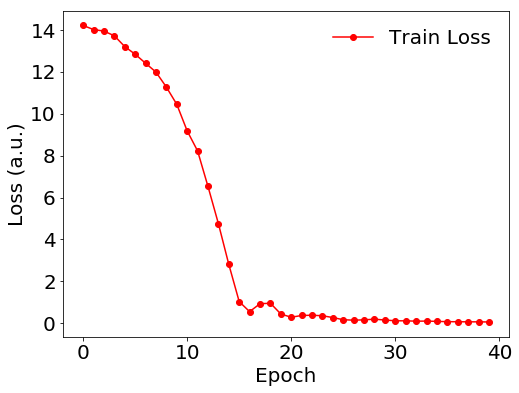

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 20

plt.figure(figsize=(8, 6))
plt.plot(model.history.history['loss'], 'o-r', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel("Loss (a.u.)")
plt.legend(frameon=False)